<a href="https://colab.research.google.com/github/AnastasiaBrinati/Progetto-ML-23-24/blob/main/task1_centralizzato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU, PReLU
import numpy as np
from keras.initializers import RandomNormal, he_normal, glorot_normal, he_uniform, glorot_uniform
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from keras.metrics import Precision, Recall, F1Score, Accuracy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 505207 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 50.1+ MB


<ipython-input-39-7be71497c9c9>:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


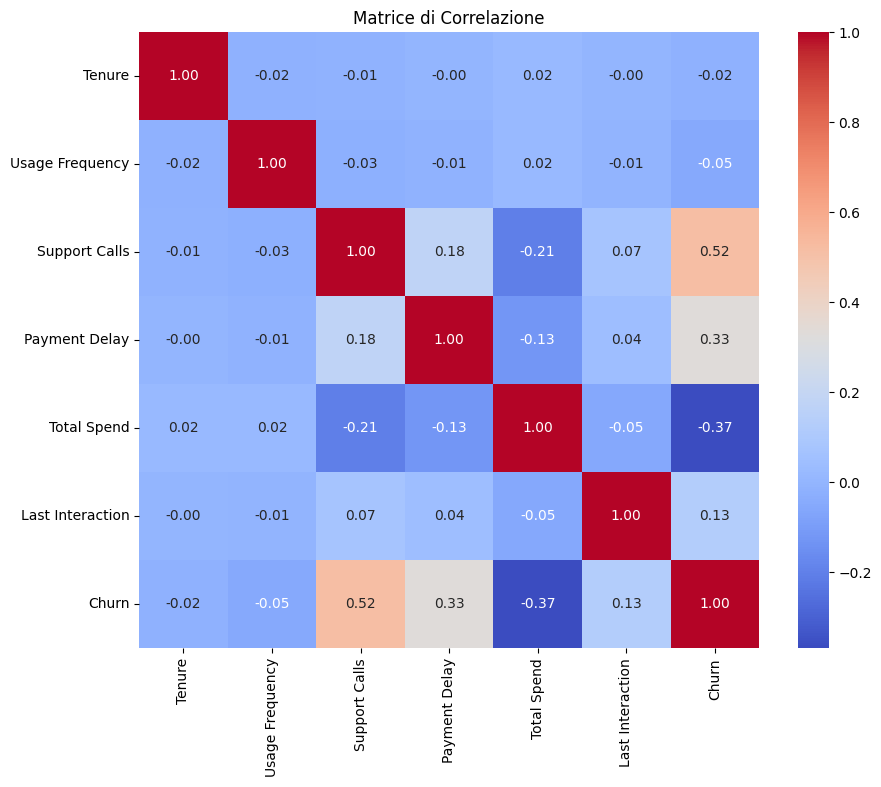

In [39]:
# Inizializza il seed per NumPy per riproducibilità
np.random.seed(42)

# Inizializza il seed per TensorFlow per riproducibilità
tf.random.set_seed(42)

# Caricamento del dataframe
df_train = pd.read_csv('/content/drive/MyDrive/customer_churn_dataset-training-master.csv')
df_test = pd.read_csv('/content/drive/MyDrive/customer_churn_dataset-testing-master.csv')
df = pd.concat([df_train, df_test])
df.info()

# Binning age
bins=[18,25,35,50,60,70,100]
df['Age_binned'] = pd.cut(df['Age'], bins)
df = df.drop(['Age','CustomerID'],axis=1)
df

import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di correlazione
correlation_matrix = df.corr()

# Crea una heatmap della matrice di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione')
plt.show()

# Define categorical and numerical features
numeric_features = ['Tenure','Support Calls','Payment Delay','Usage Frequency','Total Spend',	'Last Interaction']
categorical_features = ['Age_binned','Contract Length','Gender',	'Subscription Type']

# Divide dataset in features (X) and target (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

# Encoding target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Divide dataset in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Gestione dei dati mancanti
    ('scaler', StandardScaler()),  # Normalizzazione delle feature numeriche
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder()),  # Encoding delle variabili categoriche
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Gestione dei dati mancanti
])

# Define preprocessor for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Processing of data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

import pandas as pd

# Ottieni l'elenco delle colonne numeriche dopo la trasformazione
numeric_features_transformed = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numeric_features)

# Ottieni l'elenco delle colonne categoriche dopo la trasformazione
categorical_features_transformed = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Unisci i due elenchi di colonne
feature_names = list(numeric_features_transformed) + list(categorical_features_transformed)

# Costruisci dataframe preprocessati per il set di addestramento
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

# Costruisci dataframe preprocessati per il set di test
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Ora X_train_processed_df e X_test_processed_df sono dataframe pandas preprocessati
X_train_processed_df

# Concatenazione delle feature preprocessate con le etichette per il training set
df_train_processed = pd.concat([X_train_processed_df, pd.DataFrame({'Churn': y_train})], axis=1)

# Concatenazione delle feature preprocessate con le etichette per il test set
df_test_processed = pd.concat([X_test_processed_df, pd.DataFrame({'Churn': y_test})], axis=1)

# Salva il training set preprocessato completo in un file CSV
df_train_processed.to_csv('/content/drive/MyDrive/train.csv', index=False)

# Salva il test set preprocessato completo in un file CSV
df_test_processed.to_csv('/content/drive/MyDrive/test.csv', index=False)


In [40]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy', Precision(), Recall(), F1Score()])

  return model

In [41]:
!pip install -q -U keras-tuner

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, PReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, glorot_normal

def model_builder(hp):
    model = Sequential()

    # Tune the number of units and activation function for each Dense layer
    for i in range(hp.Int('num_layers', 2, 5, default=3)):
        hp_units = hp.Int(f'units_{i}', min_value=16, max_value=128, step=16)
        hp_activation = hp.Choice(f'activation_{i}', values=['PReLU','LeakyReLU','relu', 'tanh', 'sigmoid'])

        model.add(Dense(units=hp_units, activation=hp_activation, kernel_initializer=he_normal))

    # Output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=glorot_normal))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), F1Score()])

    return model

# Converti le etichette di classe in formato float32
y_train = np.float32(y_train)
y_test = np.float32(y_test)

# Definisci il tuner e gli altri componenti come hai fatto prima
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='multi_layer_tuning')

stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train_processed, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}.
""")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_processed, y_train, epochs=30, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch:', best_epoch)

# Retrain the model
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train_processed, y_train, epochs=best_epoch, validation_split=0.2)

# Evaluate the model on the test set
eval_result = hypermodel.evaluate(X_test_processed, y_test)

Trial 24 Complete [00h 06m 24s]
val_accuracy: 0.931562602519989

Best val_accuracy So Far: 0.9331955909729004
Total elapsed time: 01h 40m 17s

The hyperparameter search is complete. The optimal number of layers is 3.

Epoch 1/30
10105/10105 [==============================] - 35s 3ms/step - loss: 0.2364 - accuracy: 0.9206 - precision_1: 0.8948 - recall_1: 0.9712 - f1_score: 0.7140 - val_loss: 0.2184 - val_accuracy: 0.9282 - val_precision_1: 0.9002 - val_recall_1: 0.9794 - val_f1_score: 0.7141
Epoch 2/30
10105/10105 [==============================] - 33s 3ms/step - loss: 0.2161 - accuracy: 0.9278 - precision_1: 0.8955 - recall_1: 0.9850 - f1_score: 0.7140 - val_loss: 0.2099 - val_accuracy: 0.9309 - val_precision_1: 0.8995 - val_recall_1: 0.9859 - val_f1_score: 0.7141
Epoch 3/30
10105/10105 [==============================] - 31s 3ms/step - loss: 0.2112 - accuracy: 0.9290 - precision_1: 0.8958 - recall_1: 0.9870 - f1_score: 0.7140 - val_loss: 0.2060 - val_accuracy: 0.9313 - val_precision_1

In [45]:
print("[test loss, test accuracy, test precision, test recall, test F1score]:", eval_result)

[test loss, test accuracy, test precision, test recall, test F1score]: [0.2016114592552185, 0.9304051995277405, 0.8953809142112732, 0.9903172254562378, array([0.713832], dtype=float32)]


In [46]:
best_hps.values

{'num_layers': 3,
 'units_0': 96,
 'activation_0': 'tanh',
 'units_1': 96,
 'activation_1': 'tanh',
 'units_2': 64,
 'activation_2': 'tanh',
 'learning_rate': 0.001,
 'units_3': 48,
 'activation_3': 'LeakyReLU',
 'units_4': 48,
 'activation_4': 'tanh',
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [47]:
hypermodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 96)                2304      
                                                                 
 dense_10 (Dense)            (None, 96)                9312      
                                                                 
 dense_11 (Dense)            (None, 64)                6208      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17889 (69.88 KB)
Trainable params: 17889 (69.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
history.history

{'loss': [0.23643970489501953,
  0.21605278551578522,
  0.21118424832820892,
  0.20748946070671082,
  0.20475971698760986,
  0.20282790064811707,
  0.20101597905158997,
  0.20028430223464966,
  0.19893133640289307,
  0.19799481332302094,
  0.1970769166946411,
  0.19645074009895325,
  0.19552898406982422,
  0.19515305757522583,
  0.19454392790794373,
  0.19409024715423584,
  0.19335214793682098,
  0.19305241107940674,
  0.19261837005615234,
  0.1921519637107849,
  0.19192025065422058,
  0.19119976460933685,
  0.19111765921115875,
  0.19047017395496368,
  0.1902039647102356,
  0.1898481249809265,
  0.18945984542369843,
  0.1887034773826599,
  0.18855616450309753,
  0.18812675774097443],
 'accuracy': [0.9206295609474182,
  0.9278357625007629,
  0.9290141463279724,
  0.9292739629745483,
  0.9298275709152222,
  0.9303533434867859,
  0.930702805519104,
  0.9306811690330505,
  0.9309161901473999,
  0.9311450719833374,
  0.9312719106674194,
  0.9312997460365295,
  0.9313770532608032,
  0.93145

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(19, 5))
  ax1.plot(history.history['loss'], label='loss (mae)')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax2.plot(history.history['mse'], label='mse')
  ax2.plot(history.history['val_mse'], label='val_mse')
  ax3.plot(history.history['mape'], label='mape')
  ax3.plot(history.history['val_mape'], label='val_mape')
  ax4.plot(history.history['mean_squared_logarithmic_error'], label='mean_squared_logarithmic_error')
  ax4.plot(history.history['val_mean_squared_logarithmic_error'], label='val_mean_squared_logarithmic_error')
  ax5.plot(history.history['logcosh'], label='logcosh')
  ax5.plot(history.history['val_logcosh'], label='va_logcosh')
  ax6.plot(history.history['r2_score'], label='r2_score')
  ax6.plot(history.history['val_r2_score'], label='val_r2_score')